# Image Classification using advanced CNNs
- we are going to use CIFAR-10 [dataset](https://www.cs.toronto.edu/~kriz/cifar.html) of 32x32 color images

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.backends import cudnn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import time
import cupy as cp
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

model_args = {}
# we will use batch size of 64 in Stochastic Gradient Descent (SGD) optimization of the network
model_args['batch_size'] = 64
# learning rate is how fast it will descend
model_args['lr'] = .05
# SGD momentum (default: .5) momentum is a moving average of gradients (it helps to keep direction)
model_args['momentum'] = .5
# the number of epochs is the number of times you go through the full dataset
model_args['weight_decay'] = 5.e-4
model_args['epochs'] = 30

print(torch.cuda.is_available())

True


### Download CIFAR-10 dataset and define models
Similar as with MNIST we use torchvision to download the data

In [2]:

# normalize dataset
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
#mean = [.5, .5, .5]
#std = [.5, .5, .5]
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean, std)])

cifar10_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

tensored_cifar10 = []

for pic in cifar10_train:
     picture = pic[0].to("cuda:0")
     true_val = torch.tensor(pic[1], device= "cuda:0")
     pic_tensored = (picture, true_val)
     tensored_cifar10.append(pic_tensored)

torch.save(tensored_cifar10, 'tensored_cifar10.pth')

# we divide this data into training and validation subsets
train_subset, validation_subset = torch.utils.data.random_split(tensored_cifar10, [40000, 10000])
torch.save(train_subset, './data/train_subset.pt')
torch.save(validation_subset, './data/validation_subset.pt')


train_subset = torch.load('./data/train_subset.pt', map_location=torch.device('cuda:0'))

validation_subset = torch.load('./data/validation_subset.pt', map_location=torch.device('cuda:0'))
test_subset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_cifar10 = []
for pic in test_subset:
     picture = pic[0].to("cuda:0")
     true_val = torch.tensor(pic[1], device= "cuda:0")
     pic_tensored = (picture, true_val)
     test_cifar10.append(pic_tensored)
torch.save(test_cifar10, './data/test_cifar10.pth')

test_cifar10 = torch.load('./data/test_cifar10.pth', map_location=torch.device('cuda:0'))
# subsample to speedup training (colab has notebook lifetime limit)
train_subset = torch.utils.data.Subset(train_subset, range(20000))
validation_subset = torch.utils.data.Subset(validation_subset, range(5000))
test_cifar10 = torch.utils.data.Subset(test_cifar10, range(5000))


100.0%


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
train_subset = torch.load('./data/train_subset.pt', map_location=torch.device('cuda:0'))

validation_subset = torch.load('./data/validation_subset.pt', map_location=torch.device('cuda:0'))
test_cifar10 = torch.load('./data/test_cifar10.pth', map_location=torch.device('cuda:0'))
# subsample to speedup training (colab has notebook lifetime limit)
train_subset = torch.utils.data.Subset(train_subset, range(20000))
validation_subset = torch.utils.data.Subset(validation_subset, range(5000))
test_subset = torch.utils.data.Subset(test_cifar10, range(5000))

In [4]:
# define dataloaders
print(type(train_subset))
# train_subset = torch.utils.data.TensorDataset(train_subset)

train_loader = []
train_data = []
rowx = []
rowy = []
i = 0
for (x, y) in train_subset:
    if i % model_args['batch_size'] == model_args['batch_size']-1:
        train_data.append([torch.stack(rowx, dim =0).to("cuda:0"), torch.tensor(rowy, device="cuda:0")])
        rowx = []
        rowy = []
    else:
        rowx.append(x)
        rowy.append(y)
    i += 1
print(1)
print(len(train_data))
print(train_data[0])




validation_loader = []
rowx = []
rowy = []
i = 0
for x, y in validation_subset:
    if i % model_args['batch_size'] == model_args['batch_size'] - 1:
        validation_loader.append([torch.stack(rowx, dim =0).to("cuda:0"), torch.tensor(rowy, device="cuda:0")])
        rowx = []
        rowy = []
    else:
        rowx.append(x)
        rowy.append(y)
    i += 1
print(1)
print(len(validation_loader))
print(validation_loader[0])



test_loader = []
rowx = []
rowy = []
i = 0
for x, y in test_subset:
    if i % model_args['batch_size'] == model_args['batch_size'] - 1:
        
        test_loader.append([torch.stack(rowx, dim =0).to("cuda:0"), torch.tensor(rowy, device="cuda:0")])
        rowx = []
        rowy = []
    else:
        rowx.append(x)
        rowy.append(y)
    i += 1


classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

<class 'torch.utils.data.dataset.Subset'>
1
312
[tensor([[[[-0.9192, -0.8678, -0.8849,  ..., -1.2445, -0.9705, -0.7137],
          [-0.9534, -0.8849, -0.9020,  ..., -1.2274, -1.0733, -0.5253],
          [-0.9705, -0.8849, -0.8507,  ..., -1.2445, -0.9877,  0.0569],
          ...,
          [-0.1314,  0.0912,  0.4166,  ...,  1.1358,  1.1015,  1.1015],
          [ 0.1254,  0.0227,  0.1426,  ...,  1.1872,  1.1358,  1.1015],
          [-0.0116, -0.1828,  0.0912,  ...,  1.2385,  1.1872,  1.1015]],

         [[-0.7402, -0.7052, -0.7227,  ..., -0.7052, -0.4251, -0.2325],
          [-0.7927, -0.7227, -0.7402,  ..., -0.7577, -0.6001, -0.0749],
          [-0.8102, -0.7227, -0.6877,  ..., -0.8627, -0.6352,  0.3452],
          ...,
          [-0.2325, -0.0049,  0.3277,  ...,  1.1155,  1.0805,  1.0805],
          [ 0.0651, -0.0399,  0.0651,  ...,  1.1681,  1.1155,  1.0805],
          [-0.0399, -0.2325,  0.0476,  ...,  1.2206,  1.1681,  1.0805]],

         [[-0.6890, -0.6367, -0.6541,  ..., -1.0550, 

In [5]:
class SimpleCNN(nn.Module):
    '''
    simple CNN model
    '''
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 80)
        self.fc3 = nn.Linear(80, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class VGG(nn.Module):
    '''
    VGG model
    '''
    def __init__(self, features):
        super(VGG, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Linear(512, 10),
        )
        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, np.sqrt(2. / n))
                m.bias.data.zero_()

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

vgg_cfg = {
    'vgg11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'vgg19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
    'vgg22': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 256, 'M', 512, 512, 512, 512, 512, 'M', 512, 512, 512, 512, 512, 'M']
}

In [6]:
def train(model, device, train_data, optimizer, criterion, epoch_number):
    model.train()
    train_loss = torch.tensor(0., device=device)
    # get subsequent batches over the data in a given epoch
    for batch_idx, (data, target) in enumerate(train_data):
        # send data tensors to GPU (or CPU)
        
        data, target = data.to(device), target.to(device)
        # this will zero out the gradients for this batch
        optimizer.zero_grad()
        # this will execute the forward() function
        output = model(data)
        # calculate loss using c
        loss = criterion(output, target)
        # backpropagate the loss
        loss.backward()
        # update the model weights (with assumed learning rate)
        optimizer.step()
        train_loss += loss.item()
    print('Train Epoch: {}'.format(epoch_number))
    train_loss_len = torch.tensor(len(train_data), device=device)
    train_loss /= train_loss_len
    print('\tTrain set: Average loss: {:.4f}'.format(train_loss))
    return train_loss

def test(model, device, test_data, criterion, message=None):
    model.eval()
    test_loss = torch.tensor(0., device=device)
    correct = torch.tensor(0., device=device)
    # this is just inference, we don't need to calculate gradients
    with torch.no_grad():
        for data, target in test_data:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # calculate and sum up batch loss
            test_loss += criterion(output, target).cuda()
            # get the index of class with the max probability
            prediction = output.argmax(dim=1)
            #_, predicted = torch.max(outputs.data, axis=1)
            # item() returns value of the given tensor
            correct += prediction.eq(target).sum().item()
    test_loss /= len(test_data)
    accuracy = correct / len(test_data)
    if message is not None:
        print('\t{}: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
            message, test_loss, correct, len(test_data)*model_args['batch_size'], 100.*accuracy/model_args['batch_size']))
    return test_loss.cpu(), accuracy.cpu()

def run_training(model, criterion, optimizer, no_epochs, device):
    train_loss = torch.tensor([0.], device=device)
    validation_loss = torch.tensor([0.], device=device)
    validation_accuracy = torch.tensor([0.], device=device)
    test_accuracy = torch.tensor([0.], device=device)
    for epoch_number in range(1, no_epochs+1):
        train_loss = torch.cat((train_loss, torch.tensor([train(model, device, train_data, optimizer, criterion, epoch_number)], device=device)))
        
        val_loss, val_acc = test(model, device, validation_loader,
                                criterion, 'Validation set')
        
        validation_loss = torch.cat((validation_loss, torch.tensor([val_loss], device=device)))

        validation_accuracy = torch.cat((validation_accuracy, torch.tensor([val_acc], device=device)))
        
        # we also collect test accuracies for every epoch
        _, test_acc = test(model, device, test_loader, criterion)
        test_accuracy = torch.cat((test_accuracy, torch.tensor([test_acc], device=device)))

    # and select test accuracy for the best epoch (with the highest validation accuracy)
    train_loss = train_loss[1:]
    validation_loss = validation_loss[1:]
    validation_accuracy = validation_accuracy[1:]
    test_accuracy = test_accuracy[1:]
    index = torch.argmax(validation_accuracy)
    
    best_accuracy = test_accuracy[index]
    return train_loss, validation_loss, best_accuracy

def plot_loss(train_loss, validation_loss, title):
    plt.grid(True)
    plt.xlabel("subsequent epochs")
    plt.ylabel('average loss')
    plt.plot(range(1, len(train_loss)+1), train_loss, 'o-', label='training')
    plt.plot(range(1, len(validation_loss)+1), validation_loss, 'o-', label='validation')
    plt.legend()
    plt.title(title)
    plt.show()

In [16]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

## Tasks to do:

1. Check turning off the data normalization -- how this impacts network training.
2. What happens if we put *weight_decay* = 0. and increase *momentum* to .9 for VGG11 model -- why is that? (hint: observe interplay between *learning rate* and *momentum*)
3. Try to explain why the deeper VGG16 network trains longer than VGG11.
4. Compare with performance for deeper VGGs: 19 or 22 -- do we observe saturation in accuracy or even *degradation* problem?
5. Does ResNet18 (with similar depth) perform better, what for ResNet34? What about training time in this case?
6. Does transfer learning speed up training?

1. Changing data normalization | weight decay

Train Epoch: 1
	Train set: Average loss: 1.9606
	Validation set: Average loss: 1.6838, Accuracy: 1877.0/4992 (38%)
Train Epoch: 2
	Train set: Average loss: 1.5799
	Validation set: Average loss: 1.4752, Accuracy: 2270.0/4992 (45%)
Train Epoch: 3
	Train set: Average loss: 1.4230
	Validation set: Average loss: 1.3728, Accuracy: 2471.0/4992 (49%)
Train Epoch: 4
	Train set: Average loss: 1.3123
	Validation set: Average loss: 1.3057, Accuracy: 2615.0/4992 (52%)
Train Epoch: 5
	Train set: Average loss: 1.2197
	Validation set: Average loss: 1.2977, Accuracy: 2636.0/4992 (53%)
Train Epoch: 6
	Train set: Average loss: 1.1327
	Validation set: Average loss: 1.3328, Accuracy: 2626.0/4992 (53%)
Train Epoch: 7
	Train set: Average loss: 1.0571
	Validation set: Average loss: 1.3740, Accuracy: 2599.0/4992 (52%)
Train Epoch: 8
	Train set: Average loss: 0.9949
	Validation set: Average loss: 1.4374, Accuracy: 2568.0/4992 (51%)
Train Epoch: 9
	Train set: Average loss: 0.9300
	Validation set: Average loss: 1

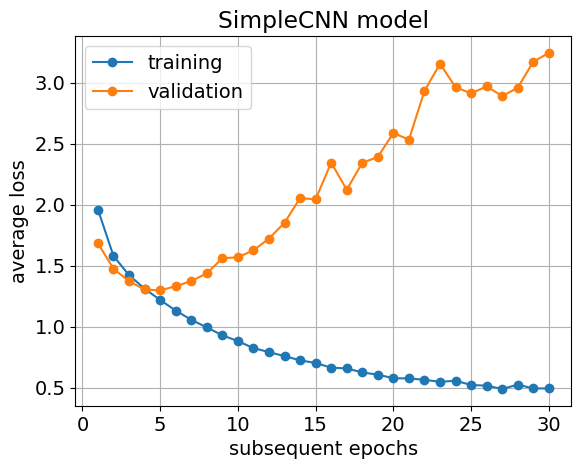

In [10]:
torch.backends.cudnn.benchmark = True
cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(),
                      lr=model_args['lr'],
                      momentum=model_args['momentum'],
                      weight_decay=0.)
no_epochs = model_args['epochs']

train_loss, val_loss, best_accuracy = run_training(model, criterion, optimizer, no_epochs, device=device)

print('\nTest accuracy for best epoch: {:.0f}%\n'.format(best_accuracy))
plot_loss(train_loss.cpu(), val_loss.cpu(), 'SimpleCNN model')

Without normalization result is worse by 4%.

2. VGG test

Train Epoch: 1
	Train set: Average loss: 2.1229
	Validation set: Average loss: 2.0710, Accuracy: 836.0/4992 (17%)
Train Epoch: 2
	Train set: Average loss: 1.8206
	Validation set: Average loss: 1.7085, Accuracy: 1609.0/4992 (32%)
Train Epoch: 3
	Train set: Average loss: 1.6368
	Validation set: Average loss: 1.5749, Accuracy: 1878.0/4992 (38%)
Train Epoch: 4
	Train set: Average loss: 1.4800
	Validation set: Average loss: 1.3915, Accuracy: 2364.0/4992 (47%)
Train Epoch: 5
	Train set: Average loss: 1.3342
	Validation set: Average loss: 1.4549, Accuracy: 2312.0/4992 (46%)
Train Epoch: 6
	Train set: Average loss: 1.2251
	Validation set: Average loss: 1.2390, Accuracy: 2659.0/4992 (53%)
Train Epoch: 7
	Train set: Average loss: 1.1571
	Validation set: Average loss: 1.2049, Accuracy: 2837.0/4992 (57%)
Train Epoch: 8
	Train set: Average loss: 1.0786
	Validation set: Average loss: 1.1993, Accuracy: 2906.0/4992 (58%)
Train Epoch: 9
	Train set: Average loss: 1.0670
	Validation set: Average loss: 1.

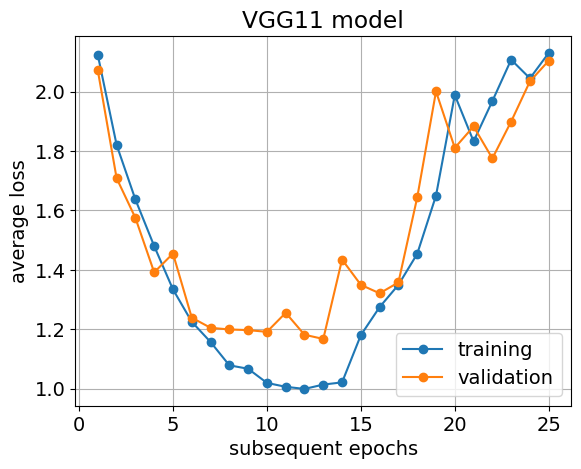

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VGG(make_layers(vgg_cfg['vgg11'])).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),
                      lr=model_args['lr'],
                      momentum=.9,
                      weight_decay=0.)
no_epochs = model_args['epochs']

train_loss_11, val_loss_11, best_accuracy = run_training(model, criterion, optimizer, no_epochs, device)

print('\nTest accuracy for best epoch: {:.0f}%\n'.format(best_accuracy))
plot_loss(train_loss_11.cpu(), val_loss_11.cpu(), 'VGG11 model')

Divergence of loss instead of convergence because of high learning rate.

3. The deeper model usually needs more time to train because of more weights need tuning and loss value is lost going deeper through model

4. VGG19

Train Epoch: 1
	Train set: Average loss: 2.2381
	Validation set: Average loss: 2.0945, Accuracy: 888.0/4992 (18%)
Train Epoch: 2
	Train set: Average loss: 2.2723
	Validation set: Average loss: 2.2959, Accuracy: 576.0/4992 (12%)
Train Epoch: 3
	Train set: Average loss: 2.2392
	Validation set: Average loss: 2.2645, Accuracy: 685.0/4992 (14%)
Train Epoch: 4
	Train set: Average loss: 2.0779
	Validation set: Average loss: 1.9604, Accuracy: 1041.0/4992 (21%)
Train Epoch: 5
	Train set: Average loss: 1.9079
	Validation set: Average loss: 1.8225, Accuracy: 1356.0/4992 (27%)
Train Epoch: 6
	Train set: Average loss: 1.8067
	Validation set: Average loss: 1.7527, Accuracy: 1540.0/4992 (31%)
Train Epoch: 7
	Train set: Average loss: 1.7032
	Validation set: Average loss: 1.6731, Accuracy: 1638.0/4992 (33%)
Train Epoch: 8
	Train set: Average loss: 1.6465
	Validation set: Average loss: 1.8645, Accuracy: 1200.0/4992 (24%)
Train Epoch: 9
	Train set: Average loss: 1.5843
	Validation set: Average loss: 1.50

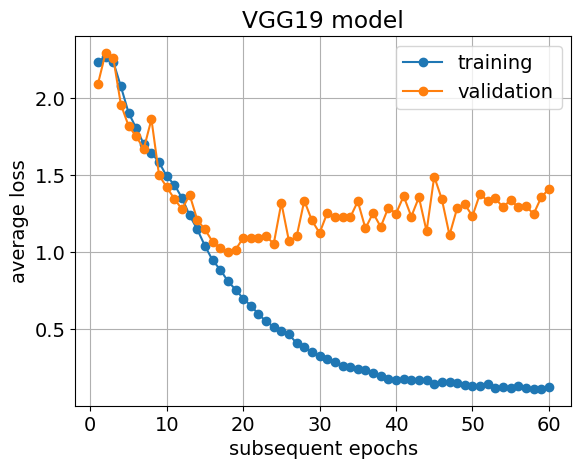

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VGG(make_layers(vgg_cfg['vgg19'])).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),
                      lr=model_args['lr'],
                      momentum=model_args['momentum'],
                      weight_decay=1.e-3)

no_epochs = model_args['epochs']*2

train_loss_19, val_loss_19, best_accuracy = run_training(model, criterion, optimizer, no_epochs, device)

print('\nTest accuracy for best epoch: {:.0f}%\n'.format(best_accuracy))
plot_loss(train_loss_19.cpu(), val_loss_19.cpu(), 'VGG19 model')

Train Epoch: 1
	Train set: Average loss: 2.3028
	Validation set: Average loss: 2.3025, Accuracy: 509.0/4992 (10%)
Train Epoch: 2
	Train set: Average loss: 2.3025
	Validation set: Average loss: 2.3023, Accuracy: 509.0/4992 (10%)
Train Epoch: 3
	Train set: Average loss: 2.3023
	Validation set: Average loss: 2.3022, Accuracy: 464.0/4992 (9%)
Train Epoch: 4
	Train set: Average loss: 2.3021
	Validation set: Average loss: 2.3020, Accuracy: 482.0/4992 (10%)
Train Epoch: 5
	Train set: Average loss: 2.3019
	Validation set: Average loss: 2.3018, Accuracy: 582.0/4992 (12%)
Train Epoch: 6
	Train set: Average loss: 2.3017
	Validation set: Average loss: 2.3014, Accuracy: 671.0/4992 (13%)
Train Epoch: 7
	Train set: Average loss: 2.3013
	Validation set: Average loss: 2.3006, Accuracy: 684.0/4992 (14%)
Train Epoch: 8
	Train set: Average loss: 2.3003
	Validation set: Average loss: 2.2989, Accuracy: 637.0/4992 (13%)
Train Epoch: 9
	Train set: Average loss: 2.2976
	Validation set: Average loss: 2.2916, Ac

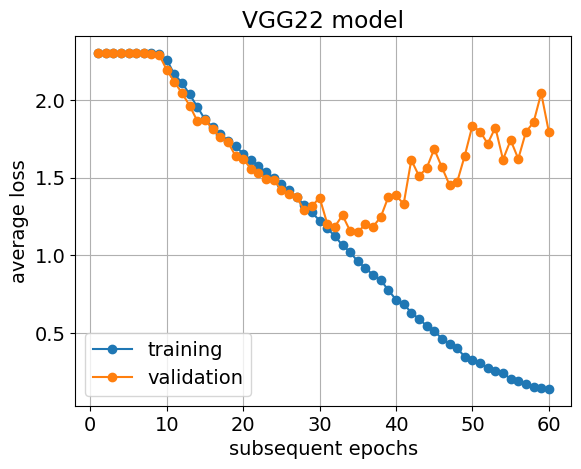

In [15]:
start = time.time()
torch.backends.cudnn.benchmark = True
cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VGG(make_layers(vgg_cfg['vgg22'])).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(),
                      lr=model_args['lr'] * 0.1,
                      momentum=model_args['momentum'],
                      weight_decay=1.e-3)

no_epochs = torch.tensor(model_args['epochs']*2, device=device)

train_loss_22, val_loss_22, best_accuracy = run_training(model, criterion, optimizer, no_epochs, device)

print('\nTest accuracy for best epoch: {:.0f}%\n'.format(100.*best_accuracy/model_args['batch_size']))
end = time.time()

print("Time needed: {:.0f}s".format(end - start))
plot_loss(train_loss_22.cpu(), val_loss_22.cpu(), 'VGG22 model')

5. ResNet

Train Epoch: 1
	Train set: Average loss: 1.7685
	Validation set: Average loss: 1.5637, Accuracy: 2218.0/4992 (44%)
Train Epoch: 2
	Train set: Average loss: 1.3156
	Validation set: Average loss: 1.4618, Accuracy: 2543.0/4992 (51%)
Train Epoch: 3
	Train set: Average loss: 1.0577
	Validation set: Average loss: 1.3959, Accuracy: 2734.0/4992 (55%)
Train Epoch: 4
	Train set: Average loss: 0.8386
	Validation set: Average loss: 1.6037, Accuracy: 2711.0/4992 (54%)
Train Epoch: 5
	Train set: Average loss: 0.6687
	Validation set: Average loss: 1.4747, Accuracy: 2890.0/4992 (58%)
Train Epoch: 6
	Train set: Average loss: 0.5368
	Validation set: Average loss: 1.4579, Accuracy: 3062.0/4992 (61%)
Train Epoch: 7
	Train set: Average loss: 0.4105
	Validation set: Average loss: 1.4831, Accuracy: 3147.0/4992 (63%)
Train Epoch: 8
	Train set: Average loss: 0.3278
	Validation set: Average loss: 1.3626, Accuracy: 3245.0/4992 (65%)
Train Epoch: 9
	Train set: Average loss: 0.2483
	Validation set: Average loss: 1

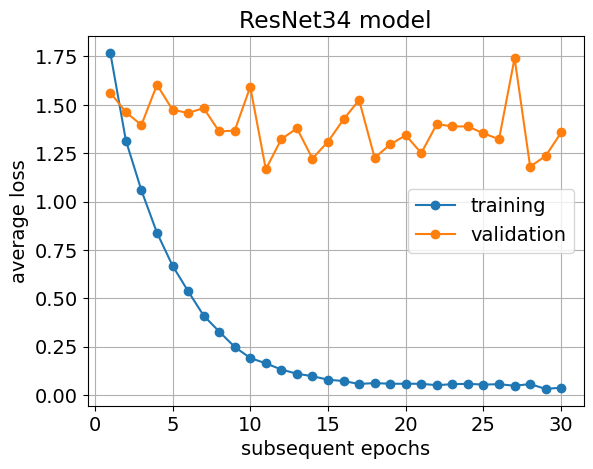

In [17]:
start = time.time()
torch.backends.cudnn.benchmark = True
cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ResNet34().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(),
                      lr=model_args['lr'],
                      momentum=model_args['momentum'],
                      weight_decay=1.e-3)

no_epochs = torch.tensor(model_args['epochs'], device=device)

train_loss_resnet34, validation_loss_resnet34, best_accuracy_resnet34 = run_training(model, criterion, optimizer, no_epochs, device)

print('\nTest accuracy for best epoch: {:.0f}%\n'.format(100.*best_accuracy_resnet34/model_args['batch_size']))
end = time.time()

print("Time needed: {:.0f}s".format(end - start))
plot_loss(train_loss_resnet34.cpu(), validation_loss_resnet34.cpu(), 'ResNet34 model')

ResNet with changes in its structure

C:\Users\Michal\PycharmProjects\ecg_class\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Michal\PycharmProjects\ecg_class\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

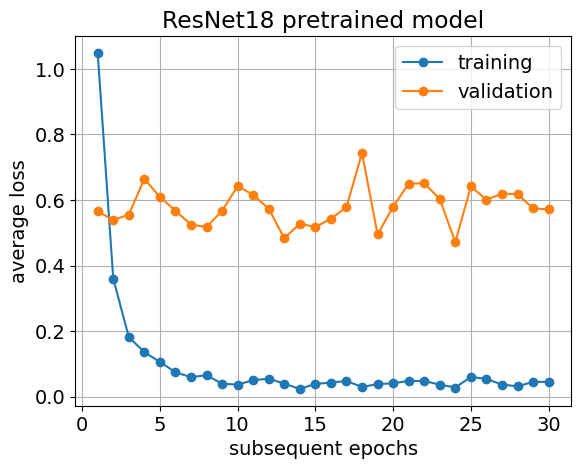

In [18]:
import torchvision.models.resnet as resnet

start = time.time()
torch.backends.cudnn.benchmark = True
cudnn.benchmark = True
model = resnet.resnet34(pretrained=True)
print(model)
model.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
model.bn1 = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
model.relu = nn.Identity()  # only input layers
model.maxpool = nn.Identity()  # only in input layers
model.fc = nn.Linear(512, 10)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(),
                      lr=model_args['lr'],
                      momentum=model_args['momentum'],
                      weight_decay=1.e-3)

no_epochs = torch.tensor(model_args['epochs'], device=device)

train_loss_resnet43_pre, validation_loss_resnet43_pre, best_accuracy_resnet43_pre = run_training(model, criterion, optimizer, no_epochs, device)

print('\nTest accuracy for best epoch: {:.0f}%\n'.format(100.*best_accuracy_resnet43_pre/model_args['batch_size']))
end = time.time()

print("Time needed: {:.0f}s".format(end - start))
plot_loss(train_loss_resnet43_pre.cpu(), validation_loss_resnet43_pre.cpu(), 'ResNet18 pretrained model')